# Neural Style Transfer

Gregor Cerar  
2023-09-15

Neural Style Transfer (NST) was a breakthrough deep learning approach
that can transfer **artistic style** from one image to another. Eager to
learn how it works, I’ve implemented the original approach from scratch.

# Introduction

[Neural Style
Transfer](https://en.wikipedia.org/wiki/Neural_style_transfer) (NST) is
a deep learning technique that combines the **content** of one image
with the **style** of another, like giving your photo a Van Gogh-esque
makeover.

Using convolutional neural networks, NST examines both images’ features
and creates a new image that merges the content’s structure with the
style’s attributes. This technique became a hit due to its novel
outcomes, leading to its adoption in various apps and platforms and
highlighting deep learning’s prowess in image transformation.

Introduced initially in “[A Neural Algorithm of Artistic
Style](https://arxiv.org/abs/1508.06576)” (Gatys, Ecker, and Bethge
2015), this method transfers art styles between images. Eager to learn
how it works, I’ve implemented the original approach from scratch and
presented a few cherry-picked transformed examples.

# Prerequisites

Before we get started, we need to install [NumPy](https://numpy.org/),
[Matplotlib](https://matplotlib.org/), [PyTorch](https://pytorch.org/)
deep learning framework, and finally,
[Torchvision](https://pytorch.org/vision/stable/index.html) library.

In [1]:
from pathlib import Path
from typing import Iterable, Optional, Sequence, Union

import numpy as np
from matplotlib import pyplot as plt

%config InlineBackend.figure_formats = {'retina', 'png'}

import torch
from torch import Tensor, nn, optim
from torch.nn import functional as F
from torchvision import models
from torchvision.io import decode_image
from torchvision.transforms import functional as VF
from torchvision.transforms import v2 as T
from torchvision.utils import make_grid
from tqdm import tqdm

# Random seed for reproducibility
SEED = 42

# Size of the output image
IMG_SIZE = 512

Although it is possible to run neural networks on a CPU, using compute
accelerators, such as GPU, will do transformation much faster. Here, I
utilize my NVIDIA RTX 3090, where I also took advantage of available
tensor cores and reduced precision data type
[bfloat16](https://en.wikipedia.org/wiki/Bfloat16_floating-point_format)
for faster transformation.

In [3]:
AMP_ENABLED = False

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
if torch.cuda.is_available():
    # Allow CuDNN internal benchmarking for architecture-specific optimizations
    torch.backends.cudnn.benchmark = True

    # Enable bfloat16 if supported
    if torch.cuda.is_bf16_supported():
        AMP_ENABLED = True
        torch.set_float32_matmul_precision("medium")

# Implementation

<figure id="fig-architecture">
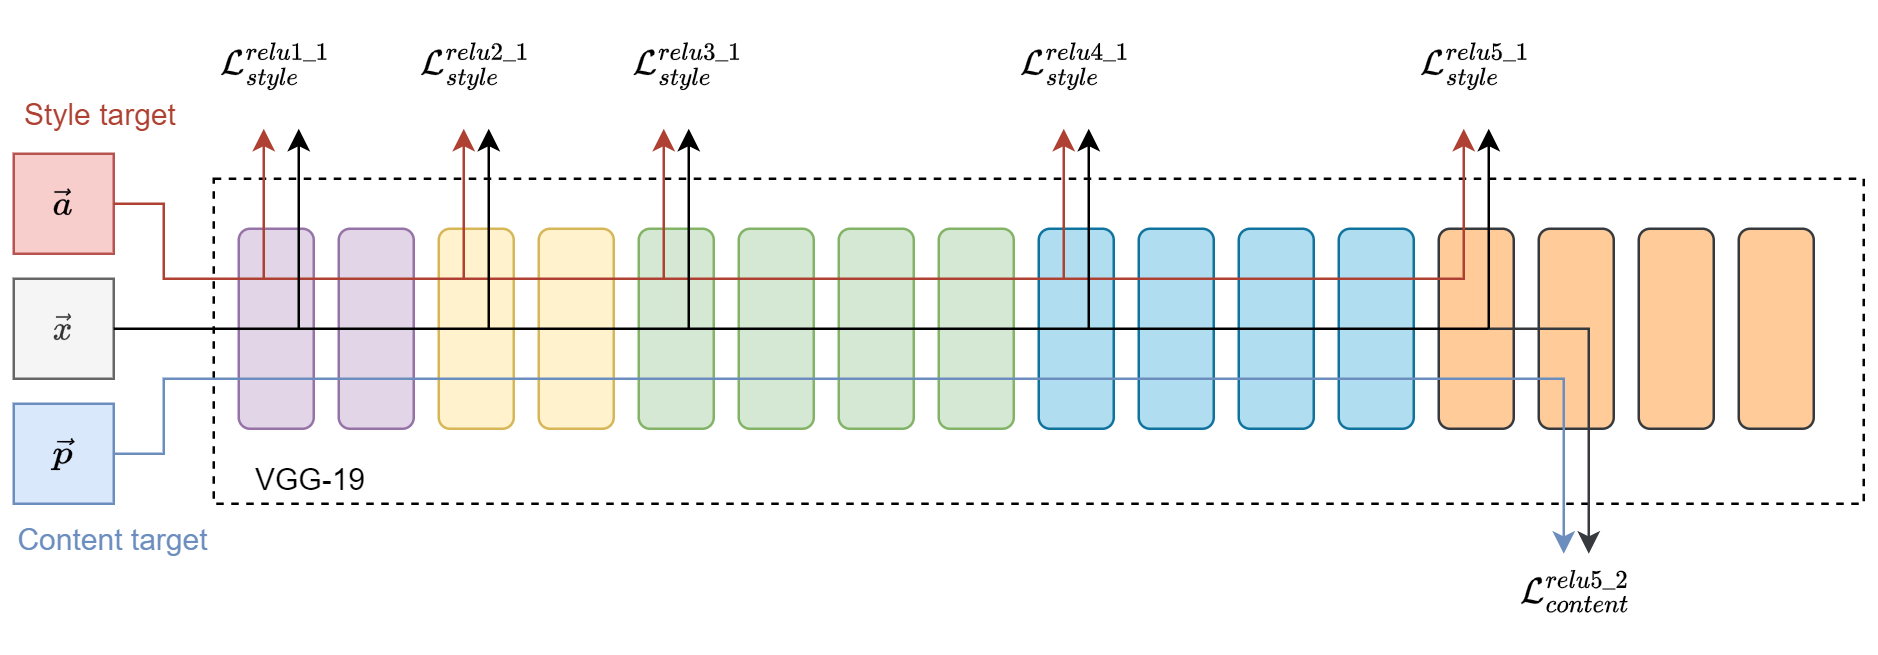
<figcaption>Figure 1: The Neural Style Transfer framework introduced by
Gatys <em>et al.</em> distinguishes style and content features from
designated layers.</figcaption>
</figure>

Implementing NST was initially confusing since it does not follow the
typical boilerplate used in deep learning. In the following sections,
I’ll delve into its implementation step by step and often refer back to
<a href="#fig-architecture" class="quarto-xref">Figure 1</a>. The steps
are as follows:

-   Prepare the content, style, and target images.
-   Prepare a pre-trained VGG neural network and prevent changes to its
    weights.
-   Introduce three unique loss metrics.
-   Adjust the neural network to extract features during
    forward-backward passes, applying gradient modifications to the
    target image. The neural network stays unchanged in the process.
-   Iterate through this process.

In [4]:
# Weights for different features (were these used by original authors?)
STYLE_LAYERS_DEFAULT = {
    "conv1_1": 0.75,
    "conv2_1": 0.5,
    "conv3_1": 0.2,
    "conv4_1": 0.2,
    "conv5_1": 0.2,
}

CONTENT_LAYERS_DEFAULT = ("conv5_2",)

CONTENT_WEIGHT = 8  # "alpha" in the literature (default: 8)
STYLE_WEIGHT = 70  # "beta" in the literature (default: 70)
TV_WEIGHT = 10  # "gamma" in the literature (default: 10)


LEARNING_RATE = 0.004
N_EPOCHS = 5_000

## Loss metrics

To effectively implement Neural Style Transfer, we need to quantify how
well the generated image matches both the **content** and **style** of
our source images. This is done using loss metrics. Let’s delve into the
specifics of these metrics and how they drive the NST process.

### Content loss metric

Content loss is calculated through Euclidean distance (*i.e.,* mean
squared error) between the respective intermediate higher-level feature
representation $F^l$ and $P^l$ of original input image $\vec{x}$ and the
content image $\vec{p}$ at layer $l$.

Hence, a given input image $\vec{x}$ is encoded in each layer of the CNN
by the filter responses to that image. A layer with $N_l$ distinct
filters has $N_l$ feature maps of size $M_l$, where $M_l$ is the height
times the width of the feature map. So the response in a layer $l$ can
be stored in a matrix $F^l \in \mathcal{R}^{N_l \times M_l}$ where
$F_{ij}^{l}$ is the activation of the $i^{th}$ filter at position $j$ in
layer $l$.

$$
\mathcal{L}_{content}(\vec{p}, \vec{x}, l) = \frac{1}{2}\sum_{i,j} (F^{l}_{ij} - P^{l}_{ij})^2
$$

In [5]:
def content_loss_func(target_features: dict[str, Tensor], precomputed_content_features: dict[str, Tensor]) -> Tensor:
    """Calculate content loss metric for give layers."""

    device = next(iter(target_features.values())).device
    content_loss = torch.tensor(0.0, device=device)

    for layer in precomputed_content_features:
        target_feature = target_features[layer]
        content_feature = precomputed_content_features[layer]

        content_loss += F.mse_loss(target_feature, content_feature)

    return content_loss

### Style loss

The style loss is more convolved than the content loss. We compute it by
comparing the Gram matrices of the feature maps from the style image and
the generated image.

First, let’s understand the [Gram
matrix](https://en.wikipedia.org/wiki/Gram_matrix). Given the feature
map $F$ of size $C \times (H \times W)$, where $C$ is the number of
channels and $H \times W$ are the spatial dimensions, the Gram matrix
$G$ is of size $C \times C$ and is computed as

$$
G^l_{ij} = \sum_k F^l_{ik} F^l_{jk}
$$

where $G_{ij}$ is the inner product between vectorized feature maps $i$
and $j$. This results in a matrix that captures the correlation between
different feature maps and, thus, the style information.

In [6]:
def gram_matrix(input: Tensor) -> Tensor:
    (b, c, h, w) = input.size()

    # reshape into (C x (H x W))
    features = input.view(b * c, h * w)

    # compute the gram product
    gram = torch.mm(features, features.t())

    return gram

The style loss between the Gram matrix of the generated image $G$ and
that of style image $A$ (at a specific layer $l$) is:

$$
E_l = \frac{1}{4 N^{2}_{l} M^{2}_{l}} \sum_{i,j}(G^l_{ij} - A^l_{ij})^2
$$

Where $E_l$ is the style loss for layer $l$, $N_l$ and $M_l$ are the
numbers of channels and height times width in the feature representation
of layer $l$, respectively. $G_{ij}^l$ and $A_{ij}^l$ are the gram
matrices of the intermediate representation of the style image $\vec{a}$
and the input base image $\vec{x}$ respectively.

The total style loss is:

$$
\mathcal{L}_{style}(\vec{a}, \vec{x}) = \sum_{l=0}^{L} w_l E_l
$$

In [7]:
def style_loss_func(
    target_features: dict[str, Tensor], style_features: dict[str, Tensor], precomputed_style_grams: dict[str, Tensor]
) -> Tensor:
    device = next(iter(target_features.values())).device
    style_loss = torch.tensor(0.0, device=device)

    for layer in style_features:
        target_feature = target_features[layer]
        target_gram = gram_matrix(target_feature)

        style_gram = precomputed_style_grams[layer]

        _, c, h, w = target_feature.shape

        weight = STYLE_LAYERS_DEFAULT[layer]
        layer_style_loss = weight * F.mse_loss(target_gram, style_gram) / (c * h * w)
        style_loss += layer_style_loss

    return style_loss

### Total Variation Loss

Total Variation (TV) loss, also known as Total Variation Regularization,
is commonly added to the Neural Style Transfer objective to encourage
spatial smoothness in the generated image. Without it, the output might
exhibit noise or oscillations, particularly in regions where the content
and style objectives don’t offer much guidance.

Given an image $\vec{x}$ of size $H \times W \times C$ (height, width,
channels), the Total Variation loss is defined as the sum of the
absolute differences between neighboring pixel values:

$$
\mathcal{L}_{TV}(\vec{x}) = \sum_{i,j} ((x_{i,j+1} - x_{i,j})^2 + (x_{i+1,j} - x_{i,j})^2)
$$

where $x_{i,j}$ is the pixel value at position $(i,j)$.

In simple terms, this loss penalizes abrupt changes in pixel values from
one to its neighbors. By minimizing this loss, the generated image
becomes smoother, reducing artifacts and unwanted noise. When combined
with content and style losses, the TV loss ensures that the resulting
image not only captures the content and style of the source images but
also looks visually coherent and smooth.

In [8]:
def total_variance_loss_func(target: Tensor) -> Tensor:
    tv_loss = F.l1_loss(target[:, :, :, :-1], target[:, :, :, 1:]) + F.l1_loss(
        target[:, :, :-1, :], target[:, :, 1:, :]
    )

    return tv_loss

### Total Loss

The total loss combines three loss metric components, each targeting a
specific aspect of the image generation process. Let’s recap the
components:

1.  **Content Loss**: Ensures the generated image resembles the content
    image’s content.
2.  **Style Loss**: Ensures the generated image captures the stylistic
    features of the style image.
3.  **Total Variation Loss**: Encourages spatial smoothness in the
    generated image, reducing artifacts and noise.

Given the above components, the total loss $\mathcal{L}_{total}$ for
Neural Style Transfer can be formulated as:

$$
\mathcal{L}_{total}(\vec{p},\vec{a},\vec{x}) = \alpha\mathcal{L}_{content}(\vec{p},\vec{x}) + \beta\mathcal{L}_{style}(\vec{a},\vec{x}) + \gamma\mathcal{L}_{TV}(\vec{x})
$$

$\alpha$, $\beta$, and $\gamma$ are weight factors that determine the
relative importance of the content, style, and the total variation
losses, respectively. By adjusting these weights, one can control the
balance between content preservation, style transfer intensity, and the
smoothness of the generated image. The algorithm aims to adjust the
generated image to minimize the total loss.

## Input preparation

Here we specify path to content and style images:

In [9]:
content_path = "./bridge.jpg"
style_path = "./walking-in-the-rain.jpg"

## Neural Style Transfer Process

For feature extraction, we’ll leverage
[VGG19](https://arxiv.org/abs/1409.1556), pre-trained on
[ImageNet](https://www.image-net.org/), same as the original authors.
Note that we set the model to evaluation mode, ensuring we only use
VGG19 to extract features without altering its weights. We also transfer
the neural network (NN) to a chosen device, ideally a GPU, for optimal
performance.

> **Note**
>
> An intriguing choice by Gatys *et al.* was to modify VGG-19, replacing
> max pooling with average pooling, aiming for visually superior
> results. However, a challenge arises: our NN was initially trained
> with `MaxPool2d` layers. Substituting them can affect activations due
> to reduced output values. To counteract this, we’ve introduced a
> custom `ScaledAvgPool2d`.

In [10]:
# We will use a frozen pre-trained VGG neural network for feature extraction.
# In the original paper, authors have used VGG19 (without batch normalization)
model = models.vgg19(weights=models.VGG19_Weights.IMAGENET1K_V1).features


# Authors in the original paper suggested using AvgPool instead of MaxPool
# for more pleasing results. However, changing the pooling also affects
# activation, so the input needs to be scaled (can't find the original source).
class ScaledAvgPool2d(nn.Module):
    def __init__(self, kernel_size, stride, padding=0, scale_factor=2.0):
        super().__init__()
        self.avgpool = torch.nn.AvgPool2d(kernel_size, stride, padding)
        self.scale_factor = scale_factor

    def forward(self, x):
        return self.avgpool(x) * self.scale_factor


# (OPTIONAL) Replace max-pooling layers with custom average pooling layers
# for i, layer in enumerate(model):
#   if isinstance(layer, torch.nn.MaxPool2d):
#       model[i] = ScaledAvgPool2d(kernel_size=2, stride=2, padding=0)

model = model.eval().requires_grad_(False).to(device)

The pretrained VGG model used normalized ImageNet samples for better
performance. For effective style transfer, we’ll follow suit to improve
feature extraction. Though images will appear altered
post-normalization, they are reverted to their original state after the
NST process. Next, we’ll transform the content and style images by:

-   Loading them from storage.
-   Resizing while maintaining aspect ratio.
-   Converting to tensors.
-   Normalizing using ImageNet weights.

In [11]:
# ImageNet normalization weights per channel
IMAGENET_MEAN = (0.485, 0.456, 0.406)
IMAGENET_STD = (0.229, 0.224, 0.225)

transform = T.Compose(
    [
        T.ToImage(),
        T.Resize(IMG_SIZE),  # Shorter edge of the image will be matched to `IMG_SIZE`
        T.ToDtype(torch.float32, scale=True),
        T.Normalize(IMAGENET_MEAN, IMAGENET_STD),
    ]
)


def load_image(path: Union[str, Path]) -> Tensor:
    img = decode_image(str(path))

    # Transform images into tensors
    img: Tensor = transform(img)

    # Add dimension to imitate batch size equal to 1: (C,H,W) -> (B,C,H,W)
    img = img.unsqueeze(0)
    return img

The following code will prepares content $\vec{p}$, style $\vec{a}$, and
target $\vec{x}$ images. The target image is a clone of the content
image and we enable computation of gradients on it.

In [12]:
# The "style" image from which we obtain style
style = load_image(style_path).to(device)

# The "content" image on which we apply style
content = load_image(content_path).to(device)

# The "target" image to store the outcome
target = content.clone().requires_grad_(True).to(device)

The function below retrieves feature maps from designated layers. As
shown in <a href="#fig-architecture" class="quarto-xref">Figure 1</a>:

-   Content feature map comes from `relu5_2`.
-   Style feature maps are sourced from `relu1_1`, `relu2_1`, `relu3_1`,
    `relu4_1`, and `relu5_1`.

In [13]:
def get_features(image: Tensor, model: nn.Module, layers: Optional[Iterable[str]] = None) -> dict[str, Tensor]:
    if layers is None:
        layers = tuple(STYLE_LAYERS_DEFAULT.keys()) + CONTENT_LAYERS_DEFAULT

    features = {}
    block_num = 1
    conv_num = 0

    x = image

    for layer in model.children():
        x = layer(x)

        if isinstance(layer, nn.Conv2d):
            # produce layer name to find matching convolutions from the paper
            # and store their output for further processing.
            conv_num += 1
            name = f"conv{block_num}_{conv_num}"
            if name in layers:
                features[name] = x

        elif isinstance(layer, (nn.MaxPool2d, nn.AvgPool2d, ScaledAvgPool2d)):
            # In VGG, each block ends with max/avg pooling layer.
            block_num += 1
            conv_num = 0

        elif isinstance(layer, (nn.BatchNorm2d, nn.ReLU)):
            pass

        else:
            raise Exception(f"Unknown layer: {layer}")

    return features

Since content and style images never change, we can precompute their
feature maps and grams to speed up the NST process.

In [14]:
# Precompute content features, style features, and style gram matrices.
content_features = get_features(content, model, CONTENT_LAYERS_DEFAULT)
style_features = get_features(style, model, STYLE_LAYERS_DEFAULT)

style_grams = {layer: gram_matrix(style_features[layer]) for layer in style_features}

Next, we will use
[Adam](https://pytorch.org/docs/stable/generated/torch.optim.Adam.html)
optimizer, where we specify that only target image $\vec{x}$ is
considered for optimization.

In [15]:
optimizer = optim.Adam([target], lr=LEARNING_RATE)

The final step of NST is to transfer style using everything we’ve
implemented. We extract feature maps, compute total loss, perform steps
using gradient descent, and repeat the process `N_EPOCHS` times.
Gradient changes will apply only to the target image.

To notably enhance NST speed, I utilized mixed precision with the unique
`bfloat16` found in newer hardware. Traditional half-precision float16
doesn’t yield the same results. I’ve tested it. Probably because of the
issue with gradient scaling.

In [16]:
pbar = tqdm(range(N_EPOCHS))

for _ in pbar:
    with torch.autocast("cuda", dtype=torch.bfloat16, enabled=AMP_ENABLED):
        target_features = get_features(target, model)

        content_loss = CONTENT_WEIGHT * content_loss_func(target_features, content_features)
        style_loss = STYLE_WEIGHT * style_loss_func(target_features, style_features, style_grams)
        tv_loss = TV_WEIGHT * total_variance_loss_func(target)

        total_loss = content_loss + style_loss + tv_loss

    optimizer.zero_grad()
    total_loss.backward()

    optimizer.step()

    pbar.set_postfix_str(
        f"total_loss={total_loss.item():.2f} "  # noqa: E501
        f"content_loss={content_loss.item():.2f} "
        f"style_loss={style_loss.item():.2f} "
        f"tv_loss={tv_loss.item():.2f}"
    )

100%|██████████| 5000/5000 [01:32<00:00, 54.10it/s, total_loss=43.90 content_loss=8.75 style_loss=29.05 tv_loss=6.10]     

As mentioned before, images need to be denormalized (*i.e.* reverted
back) to correct colors. After that we compare content, style and target
images side-by-side.

In [17]:
class InverseNormalize:
    def __init__(self, mean: Sequence[float], std: Sequence[float]) -> None:
        self.mean = torch.as_tensor(mean)
        self.std = torch.as_tensor(std)

    def __call__(self, x_norm: Tensor) -> Tensor:
        # Ensure mean and std have the correct shape
        mean = self.mean.to(x_norm.device).view(-1, 1, 1)
        std = self.std.to(x_norm.device).view(-1, 1, 1)

        # Inverse normalization: x = x_normalized * std + mean
        x = x_norm.mul(std).add(mean)
        return x


class Clip(object):
    def __init__(self, vmin: float = 0.0, vmax: float = 1.0) -> None:
        self.vmin = vmin
        self.vmax = vmax

    def __call__(self, x: Tensor) -> Tensor:
        return torch.clamp(x, self.vmin, self.vmax)


inv_transform_preview = T.Compose(
    [
        InverseNormalize(IMAGENET_MEAN, IMAGENET_STD),
        T.Resize(IMG_SIZE, antialias=True),
        T.CenterCrop((IMG_SIZE, IMG_SIZE)),
        Clip(),
    ]
)

imgs = [inv_transform_preview(i.detach().squeeze().cpu()) for i in (content, style, target)]

grid = make_grid(imgs)


def show(imgs):
    if not isinstance(imgs, list):
        imgs = [imgs]

    fig, axs = plt.subplots(ncols=len(imgs), figsize=(21, 7), squeeze=False, dpi=92, tight_layout=True, frameon=False)
    for i, img in enumerate(imgs):
        img = img.detach()
        img = VF.to_pil_image(img)
        axs[0, i].imshow(np.asarray(img))
        axs[0, i].set(xticklabels=[], yticklabels=[], xticks=[], yticks=[])


show(grid)

# Conclusions

Neural Style Transfer (NST) was a breakthrough deep learning approach
that can transfer **artistic style** from one image to another. The key
takeaway from my experience is the incredible potential of neural
networks in merging art and tech, seamlessly blending the styles of
different artworks with original images.

What stood out was the use of a pre-trained neural network for feature
extraction, extracting feature maps from particular layers, and then the
ability to balance the content and style weight parameters to maintain
the essence of the original image while effectively imitating the
artistic style.

Although the NST achieves pleasing results, it was soon overshadowed by
faster and more advanced methods, such as
[DALL-E](https://en.wikipedia.org/wiki/DALL-E), [Stable
Diffusion](https://en.wikipedia.org/wiki/Stable_Diffusion), and
[Midjourney](https://en.wikipedia.org/wiki/Midjourney). However, it
represented a significant milestone toward artistic AI and generative AI
models.

# Acknowledgements

Helpful articles and code repositories while writing my implementation:

-   Gregor Koehler *et al.*
    [gkoehler/pytorch-neural-style-transfer](https://nextjournal.com/gkoehler/pytorch-neural-style-transfer)
    (best resource in my opinion)
-   Ritul’s [Medium
    article](https://medium.com/udacity-pytorch-challengers/style-transfer-using-deep-nural-network-and-pytorch-3fae1c2dd73e)
    (good resource)
-   Pragati Baheti
    [blog](https://www.v7labs.com/blog/neural-style-transfer) visually
    present style extraction
-   Aleksa Gordić
    ([gordicaleksa/pytorch-neural-style-transfer](https://github.com/gordicaleksa/pytorch-neural-style-transfer))
-   [ProGamerGov/neural-style-pt](https://github.com/ProGamerGov/neural-style-pt/blob/master/neural_style.py)
-   Katherine Crowson
    ([rowsonkb/style-transfer-pytorch](https://github.com/crowsonkb/style-transfer-pytorch/blob/master/style_transfer/style_transfer.py))
-   Derrick Mwiti’s [Medium
    article](https://heartbeat.comet.ml/neural-style-transfer-with-pytorch-49e7c1fe3bea)
-   Aman Kumar Mallik’s [Medium
    article](https://towardsdatascience.com/implementing-neural-style-transfer-using-pytorch-fd8d43fb7bfa)

I want to acknowledge the following artworks:

-   “Gray Bridge and Trees” by Martin Damboldt
-   “Walking in the Rain” by Leonid Afremov
-   “The Starry Night” by Vincent van Gogh

For a complete list of acknowledgments, please visit my GitHub
repository:

-   [gcerar/pytorch-neural-style-transfer](https://github.com/gcerar/pytorch-neural-style-transfer/#acknowledgment)

# Appendix

## Examples

A few cherry-picked examples of style transfer:

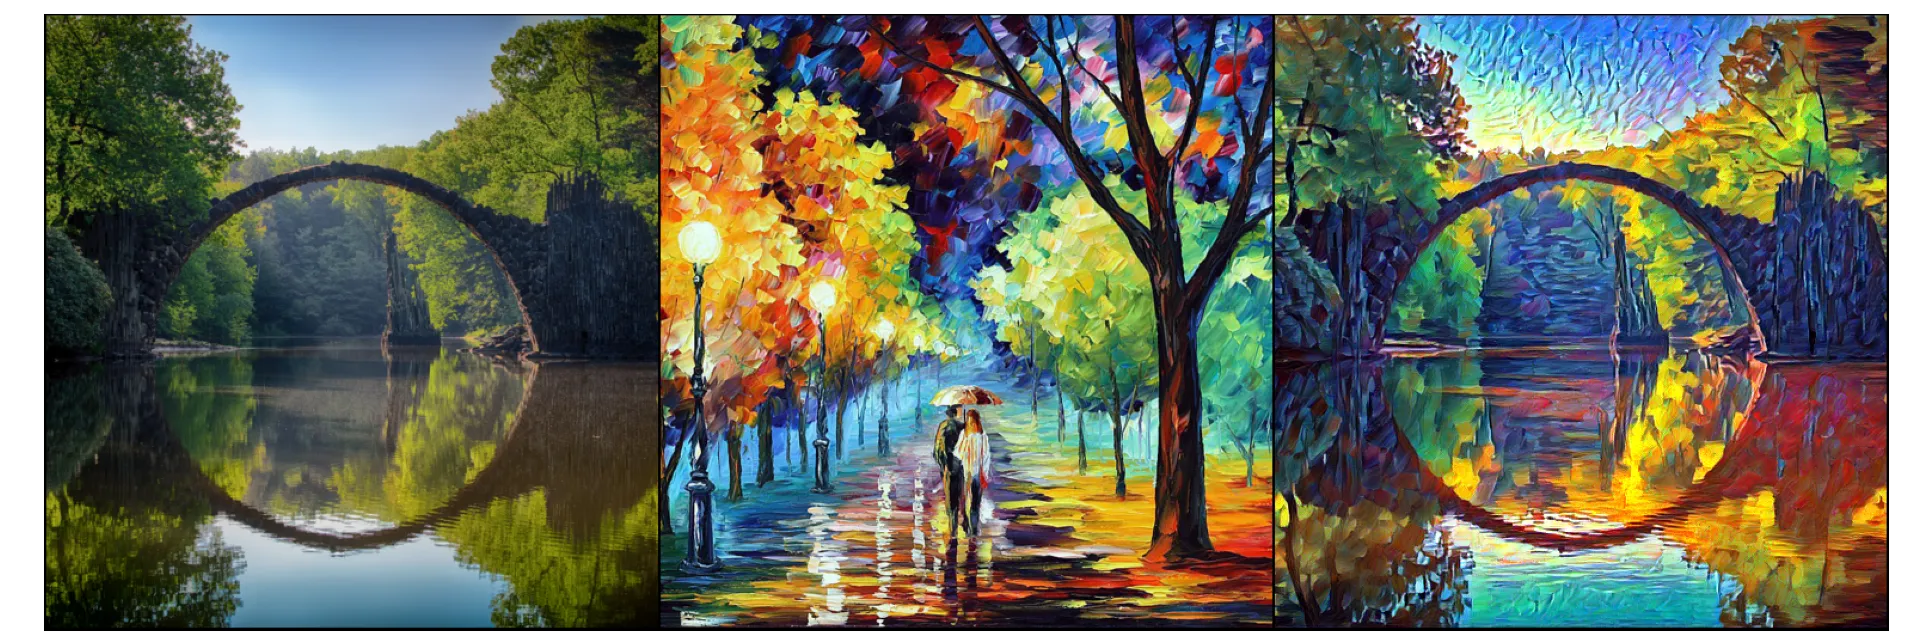 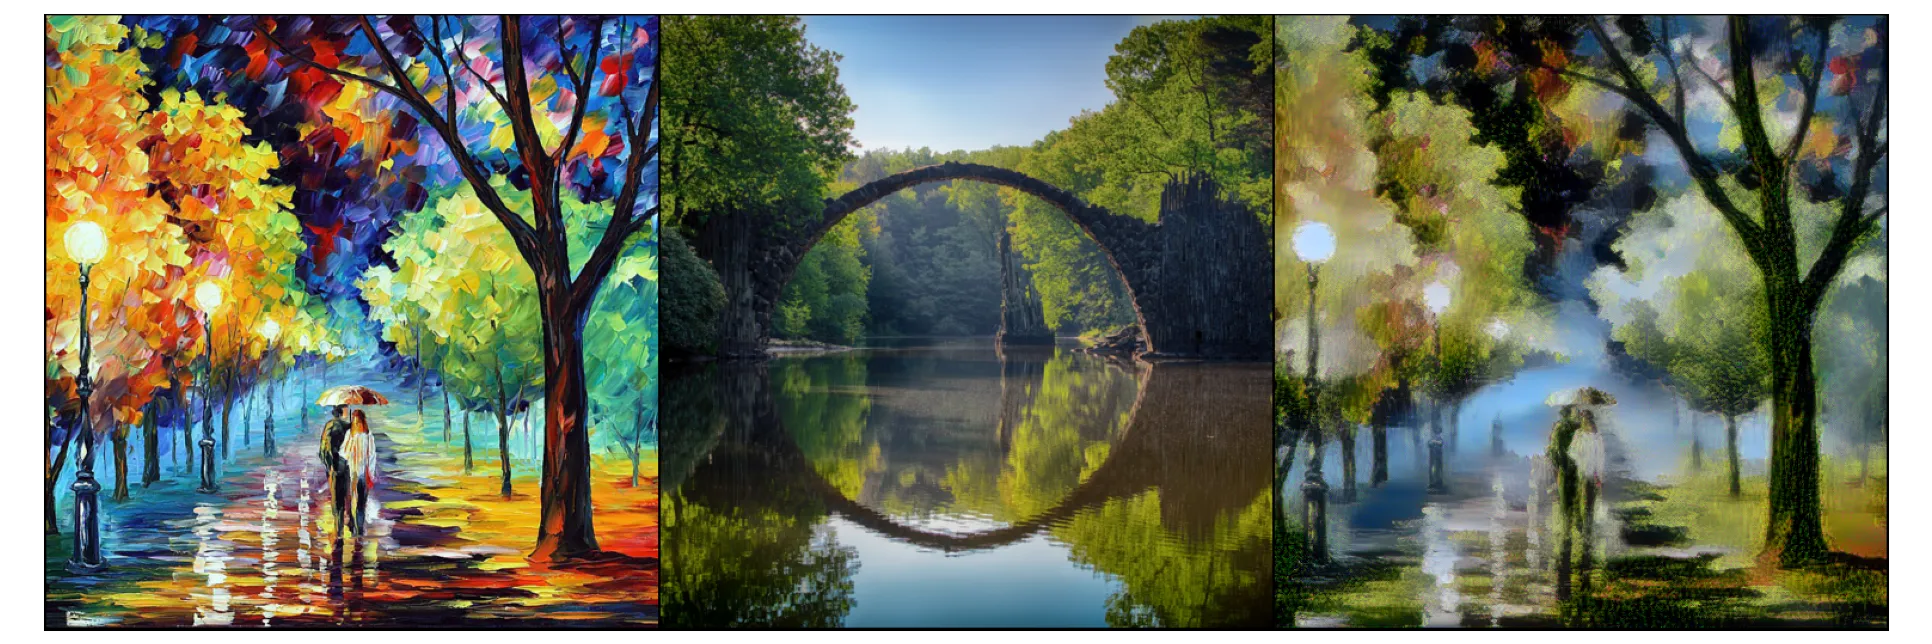
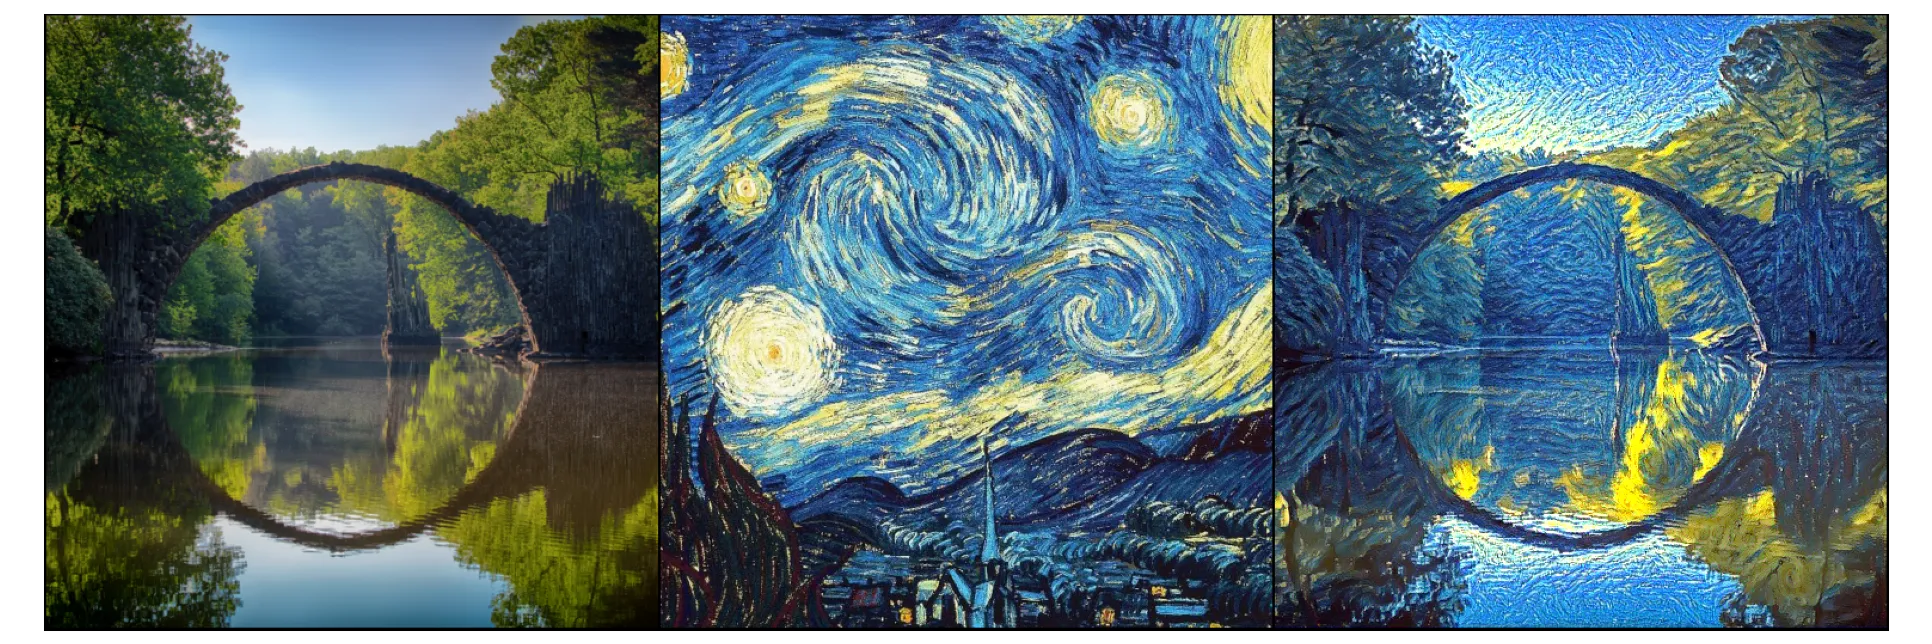 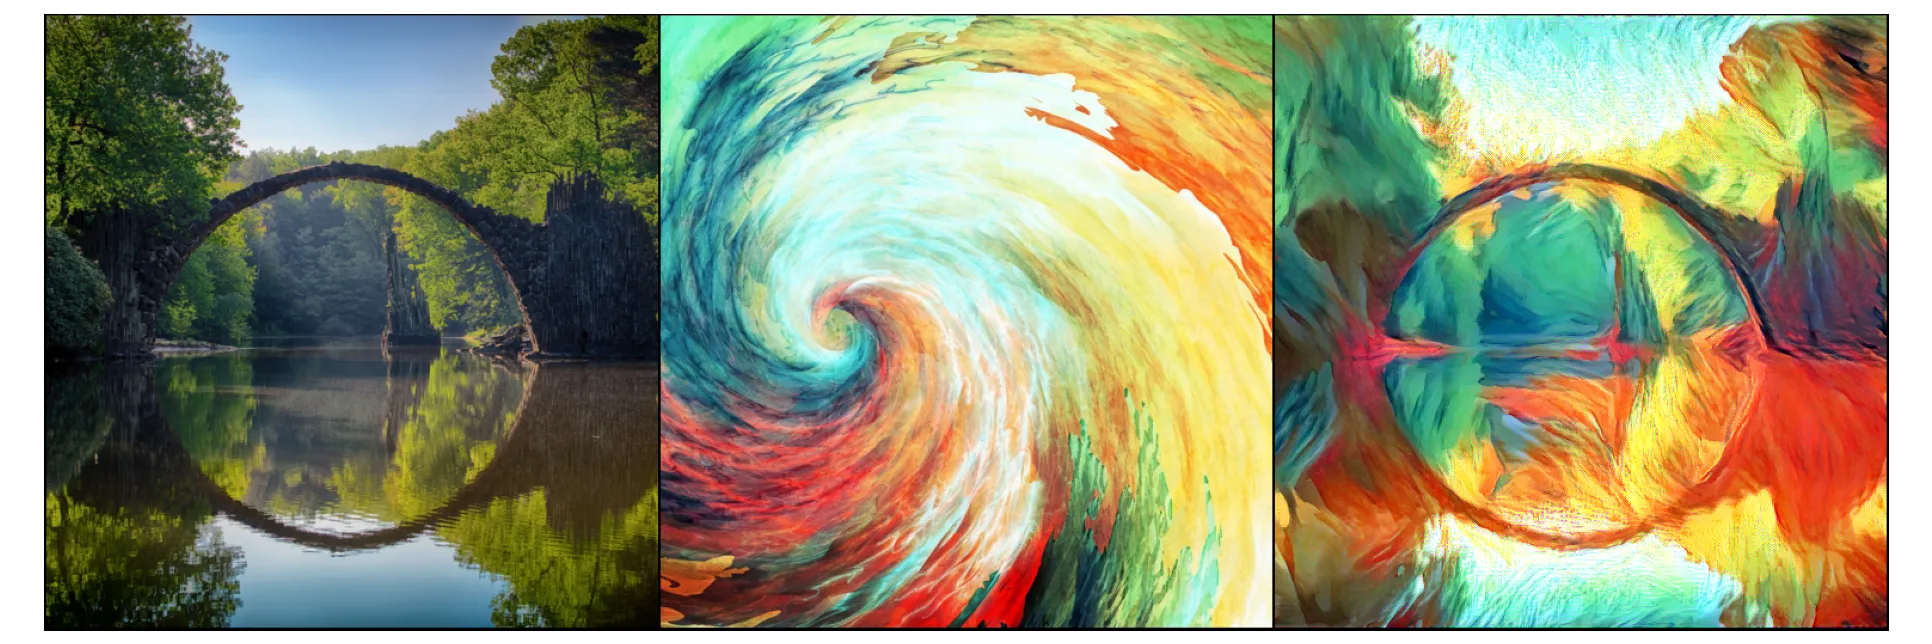

Gatys, Leon A, Alexander S Ecker, and Matthias Bethge. 2015. “A Neural
Algorithm of Artistic Style.” *arXiv Preprint arXiv:1508.06576*.